In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from skopt  import BayesSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
#Загрузим данные
data = pd.read_csv('data_eda.csv')

In [3]:
#Выделим целевой признак и фичи
X = data.drop(columns = ['IC50, mM','CC50, mM','SI'])
y = data.loc[:,['CC50, mM']]

In [4]:
# Получим тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

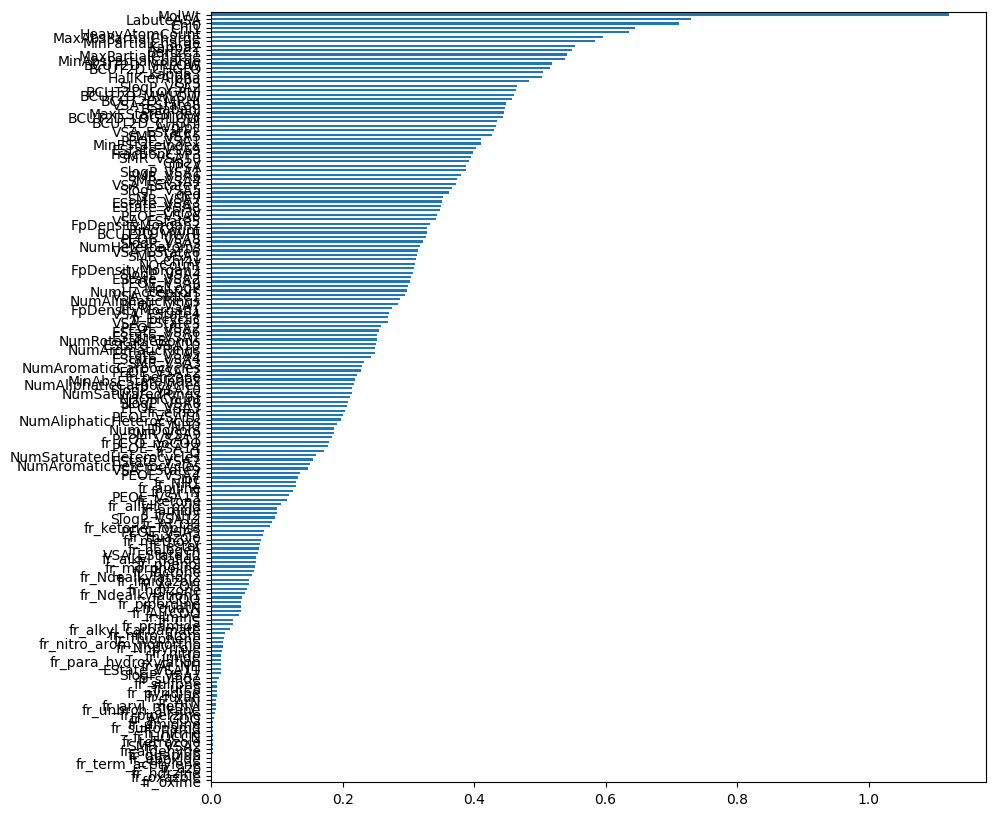

In [5]:
#Воспользуемся mutual_info_regression для feature selection
mutual = mutual_info_regression(X_train, y_train.values.ravel())
main_features = pd.Series(mutual, X_train.columns[0:len(X_train.columns)])
main_features = main_features.sort_values()
plt.figure(figsize=(10,10))
main_features.plot(kind='barh')
plt.show()

In [6]:
# После всех экспериментов оставим только 15 лучший признак
selector = SelectKBest(mutual_info_regression, k=15)
X_train_sel = selector.fit_transform(X_train, y_train.values.ravel())
X_test_sel = selector.transform(X_test)

In [7]:
#Выполним масштабирование признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_sel)
X_test = scaler.transform(X_test_sel)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

<Axes: >

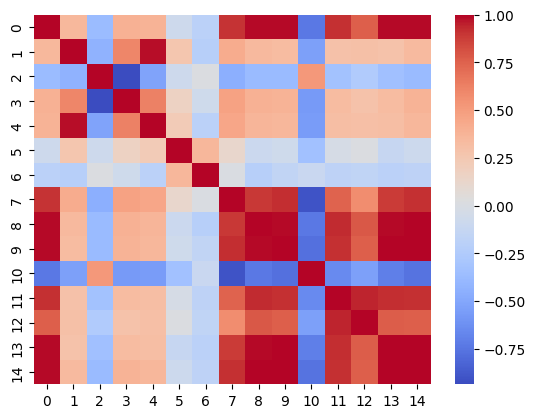

In [8]:
#Посмотрим, сколько высококореллированных признаков осталось после Feature_sel
sns.heatmap(X_train.corr(), cmap = 'coolwarm')

In [9]:
corr_mat = X_train.corr()
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col].abs()>0.9)]
print(f'Высококореллированные признаки: {high_corr}')

Высококореллированные признаки: [3, 4, 7, 8, 9, 10, 11, 12, 13, 14]


In [10]:
#Удалим высококореллированные признаки
X_train = X_train.drop(columns = [4, 8, 9, 10, 11, 12, 13, 14])
X_test = X_test.drop(columns = [4, 8, 9, 10, 11, 12, 13, 14])

In [11]:
#Создадим словарик с моделями перед BayesSearch
models = {
    "DecisionTree": (DecisionTreeRegressor(), {
        'max_depth': (2, 21),
        'min_samples_split': (2, 11),
        'min_samples_leaf': (2, 11)
    }),
    "RandomForest": (RandomForestRegressor(), {
        'n_estimators': (50, 500),
        'max_depth': (1, 50),
        'min_samples_split': (2, 25),
        'min_samples_leaf': (2, 11),
        'max_features': ['sqrt', 'log2', None]
    }),
    "KNN": (KNeighborsRegressor(), {
        'n_neighbors': (1, 21),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }),
    "LinearRegression": (LinearRegression(), {
        'fit_intercept': [True, False]
    }),
    "SVR": (SVR(), {
        'C': (0.1, 100.0, 'log-uniform'),
        'epsilon': (0.01, 10, 'log-uniform'),
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [2, 3, 4]
    }),
    "XGBoost_Regressor": (XGBRegressor(random_state=42, n_jobs=-1), {
        'n_estimators': (100, 1000),
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'max_depth': (3, 10),
        'subsample': (0.6, 1.0, 'uniform'),
        'colsample_bytree': (0.6, 1.0, 'uniform'),
        'gamma': (0, 5, 'uniform'),
        'reg_alpha': (0, 1.0, 'uniform'),
        'reg_lambda': (0, 1.0, 'uniform')
    }),

    "LightGBM_Regressor": (LGBMRegressor(random_state=42, n_jobs=-1), {
        'n_estimators': (100, 1000),
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'max_depth': (3, 10),
        'num_leaves': (20, 150),
        'subsample': (0.6, 1.0, 'uniform'),
        'colsample_bytree': (0.6, 1.0, 'uniform'),
        'reg_alpha': (0, 1.0, 'uniform'),
        'reg_lambda': (0, 1.0, 'uniform'),
    })
}

# Перебор моделей
all_models_results = {}

for name, (model, params) in models.items():
    print(f"Обучаем {name}...")

    # Байесовская оптимизация гиперпараметров
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=params,
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )

    # Обучение модели
    bayes_search.fit(X_train, y_train)

    all_models_results[name] = {
        "best_params": bayes_search.best_params_,
        "best_score": bayes_search.best_score_,
        "best_model": bayes_search.best_estimator_
    }

    print(f"{name} - MSE: {-bayes_search.best_score_:.4f}")

Обучаем DecisionTree...


C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20), np.int64(8), np.int64(10)] before, using random point [np.int64(16), np.int64(8), np.int64(5)]
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(8), np.int64(11)] before, using random point [np.int64(10), np.int64(5), np.int64(9)]
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(8), np.int64(11)] before, using random point [np.int64(10), np.int64(7), np.int64(4)]
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(8), np.int64(11

DecisionTree - MSE: 269909.2729
Обучаем RandomForest...


C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(30), np.str_('log2'), np.int64(2), np.int64(2), np.int64(500)] before, using random point [np.int64(32), 'sqrt', np.int64(9), np.int64(7), np.int64(349)]
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(28), np.str_('log2'), np.int64(2), np.int64(2), np.int64(500)] before, using random point [np.int64(48), None, np.int64(3), np.int64(21), np.int64(176)]
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(29), np.str_('log2'), np.int64(2), np.int64(2), np.int64(500)] before, using random point [np.int64(40), None, np.int64(8), np.int64(9), np.int64(135)]
  warnings.warn(
C:\Users\roman\anaconda3\

RandomForest - MSE: 213359.9894
Обучаем KNN...


C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of s

KNN - MSE: 253454.8626
Обучаем LinearRegression...


C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_] before, using random point [True]
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_] before, using random point [False]
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_] before, using random point [True]
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_] before, using random point [True]
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_] before, using r

LinearRegression - MSE: 374185.5474
Обучаем SVR...


C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, np.int64(4), 10.0, np.str_('rbf')] before, using random point [0.10993728927784985, 3, 2.9893198692562386, 'linear']
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, np.int64(4), 10.0, np.str_('rbf')] before, using random point [3.3798651933732184, 4, 7.617750637091195, 'rbf']
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, np.int64(4), 10.0, np.str_('rbf')] before, using random point [0.3315448140110843, 4, 2.5308089702034207, 'rbf']
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10

SVR - MSE: 350162.9019
Обучаем XGBoost_Regressor...
XGBoost_Regressor - MSE: 209574.9250
Обучаем LightGBM_Regressor...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 765, number of used features: 7
[LightGBM] [Info] Start training from score 594.571817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [12]:
all_models_results.items()

dict_items([('DecisionTree', {'best_params': OrderedDict({'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 7}), 'best_score': np.float64(-269909.2729490824), 'best_model': DecisionTreeRegressor(max_depth=6, min_samples_leaf=8, min_samples_split=7)}), ('RandomForest', {'best_params': OrderedDict({'max_depth': 38, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 397}), 'best_score': np.float64(-213359.98943285816), 'best_model': RandomForestRegressor(max_depth=38, max_features=None, min_samples_leaf=2,
                      min_samples_split=3, n_estimators=397)}), ('KNN', {'best_params': OrderedDict({'n_neighbors': 3, 'p': 2, 'weights': 'distance'}), 'best_score': np.float64(-253454.86261117313), 'best_model': KNeighborsRegressor(n_neighbors=3, weights='distance')}), ('LinearRegression', {'best_params': OrderedDict({'fit_intercept': True}), 'best_score': np.float64(-374185.5474419358), 'best_model': LinearRegression()}), ('SVR', {'best_para

In [13]:
for model, best_model in all_models_results.items():
    print(f'Результаты {model} на отложенной выборке:')
    y_pred = best_model['best_model'].predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'MSE для модели {model}: {mse}')
    print(f'R2 для модели {model}: {r2}')

Результаты DecisionTree на отложенной выборке:
MSE для модели DecisionTree: 206390.80015164372
R2 для модели DecisionTree: 0.33531541117901
Результаты RandomForest на отложенной выборке:
MSE для модели RandomForest: 152702.5346101238
R2 для модели RandomForest: 0.5082192551476244
Результаты KNN на отложенной выборке:
MSE для модели KNN: 182517.16139876944
R2 для модели KNN: 0.4122008137573028
Результаты LinearRegression на отложенной выборке:
MSE для модели LinearRegression: 260792.54691278157
R2 для модели LinearRegression: 0.16011379051325214
Результаты SVR на отложенной выборке:
MSE для модели SVR: 266554.89591876586
R2 для модели SVR: 0.14155606130792142
Результаты XGBoost_Regressor на отложенной выборке:
MSE для модели XGBoost_Regressor: 144696.453125
R2 для модели XGBoost_Regressor: 0.534002959728241
Результаты LightGBM_Regressor на отложенной выборке:
MSE для модели LightGBM_Regressor: 147631.47890093163
R2 для модели LightGBM_Regressor: 0.5245506641856057
